__Skip Connection / Bottleneck Skip connection__

![image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99F0453F5C47F1741338F0)

- ResNet50 부터는 연산량의 줄이기 위해 Residual Block 내에, 1x1, 3x3, 1x1 컨볼루션 연산을 쌓았다. Inception에서 배웠던 것과 같은 개념이다. 1x1 컨볼루션 연산으로 피쳐맵의 갯수를 줄였다가 3x3을 거친 후, 1x1 컨볼루션 연산으로 차원을 늘려준다. 이 과정이 병목 같다 하여 병목레이어(bottleneck layer)라고 부른다.

__Residual Block / Identity Block__

![image](https://datascienceschool.net/upfiles/2e104ff279804e839cef46fc58ef16e7.png)

-  이미지가 반으로 작아진 경우, Identity Block이 사용되며, 입력값을 바로 더하지 않고, 1x1 컨볼루션 연산을 스트라이드 2로 설정하여 피쳐맵의 크기와 갯수를 맞추어준 다음 더해준다. 이를 프로젝션 숏컷(projection shortcut)

__ResNet Structrue by layer__

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99167C335C47F0E315)

__Grouped Convolution__

![image](https://miro.medium.com/max/6630/1*dBrsVP0nt_PrBlICSBTttg.png)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from utils import one_hot, train_valid_split, random_minibatch, shuffle
from utils import training_history

# Load Data

In [2]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/8ch/train'
npy_files = os.listdir(train_dir)
npy_files

['ball_7.npy',
 'ball_14.npy',
 'ball_21.npy',
 'inner_7.npy',
 'inner_14.npy',
 'inner_21.npy',
 'outer_7.npy',
 'outer_14.npy',
 'outer_21.npy',
 'normal.npy']

In [3]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (750, 100, 100, 8) (750, 10)
ball_7: (750, 100, 100, 8) (750, 10)
ball_14: (750, 100, 100, 8) (750, 10)
ball_21: (750, 100, 100, 8) (750, 10)
inner_7: (750, 100, 100, 8) (750, 10)
inner_14: (750, 100, 100, 8) (750, 10)
inner_21: (750, 100, 100, 8) (750, 10)
outer_7: (750, 100, 100, 8) (750, 10)
outer_14: (750, 100, 100, 8) (750, 10)
outer_21: (750, 100, 100, 8) (750, 10)


# Data split

In [4]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)


In [5]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (6380, 100, 100, 8) (6380, 10)
Validation set: (1120, 100, 100, 8) (1120, 10)


# Model

In [6]:
input_h = 100
input_w = 100
input_ch = 8

ch = 16
# 50 50 16

r_ch_1 = 32
# 25 25 32

r_ch_2 = 32
# 12 12 16

r_ch_3 = 64
# 12 12 32

r_ch_4 = 128
# 6 6 128

n_output = 10

In [14]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
batch_prob = tf.placeholder(tf.bool, name = 'bn_prob')

class ResNet50_grouped:
    def __init__(self, n_g_1, n_g_2, n_g_3, n_g_4, ch, r_ch_1, r_ch_2, r_ch3, r_ch4):
        self.n_g_1 = n_g_1
        self.n_g_2 = n_g_2
        self.n_g_3 = n_g_3
        self.n_g_4 = n_g_4
        self.ch = ch
        self.r_ch_1 = r_ch_1
        self.r_ch_2 = r_ch_2
        self.r_ch_3 = r_ch_3
        self.r_ch_4 = r_ch_4
        
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME")
        conv = tf.layers.batch_normalization(conv, center=True, scale=True, training=batch_prob)
        if activation == True:
            conv = tf.nn.relu(conv)
        return conv

    def grouped_conv(self, x, n_g, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        input_groups = tf.split(value = x, num_or_size_splits= n_g, axis = -1)

        output_groups = [
            tf.layers.conv2d(input_groups[i], filters = channel/n_g, kernel_size = kernel_size, strides = strides, padding = "SAME")
            for i in range(n_g)
        ]
        output = tf.concat(output_groups, axis = -1)
        output = tf.layers.batch_normalization(output, center=True, scale=True, training=batch_prob)
        if activation != False:
            output = tf.nn.relu(output)
        return output
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def res_block(self, x, n_g, channel):
        x_shortcut = x
        conv_a = self.grouped_conv(x, n_g, channel/4, kernel_size = [1, 1])
        conv_b = self.grouped_conv(conv_a, n_g, channel/4, kernel_size = [3, 3])
        conv_c = self.grouped_conv(conv_b, n_g, channel, kernel_size = [1, 1])
        return tf.nn.relu(conv_c + x_shortcut)

    def first_id_block(self, x, n_g, channel):
        x_shortcut = x
        conv_2a = self.grouped_conv(x, n_g, channel/4, kernel_size = [1, 1])
        conv_2b = self.grouped_conv(conv_2a, n_g, channel/4, kernel_size = [3, 3])
        conv_2c = self.grouped_conv(conv_2b, n_g, channel, kernel_size = [1, 1], activation = False)
        conv_1 = self.grouped_conv(x, n_g, channel, kernel_size = [1, 1], activation = False)
        return tf.nn.relu(conv_1 + conv_2c)
    
    def id_block(self, x, n_g, channel):
        x_shortcut = x
        conv_2a = self.grouped_conv(x, n_g, channel/4, kernel_size = [1, 1], strides = (2, 2))
        conv_2b = self.grouped_conv(conv_2a, n_g, channel/4, kernel_size = [3, 3])
        conv_2c = self.grouped_conv(conv_2b, n_g, channel, kernel_size = [1, 1], activation = False)
        conv_1 = self.grouped_conv(x, n_g, channel, kernel_size = [1, 1], strides = (2, 2), activation = False)
        return tf.nn.relu(conv_1 + conv_2c)

    def fc_layer(self, gap, n_output = None):
        flatten = tf.layers.flatten(gap)
        output = tf.layers.dense(inputs = flatten, units = n_output)
        return output

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return gap

    def res_block_rep(self, x, n_g, target_ch, n_rep):
        for _ in range(n_rep):
            x = self.res_block(x, n_g, target_ch)
        return x

    def inf(self, x):
        """
        conv_1: 1
        id_~ + resnet_~: 16 x 3 = 48
        fc_lay: 1

        total: 50
        """
        conv_1 = self.grouped_conv(x, self.n_g_1, self.ch)
        maxp_1 = self.maxp(conv_1)
        id_1 = self.first_id_block(maxp_1, self.n_g_1, self.r_ch_1)
        res_1 = self.res_block_rep(id_1, self.n_g_1, self.r_ch_1, n_rep = 2)
        id_2 = self.id_block(res_1, self.n_g_2, self.r_ch_2)
        res_2 = self.res_block_rep(id_2, self.n_g_2, self.r_ch_2, n_rep = 3)
        id_3 = self.id_block(res_2, self.n_g_3, self.r_ch_3)
        res_3 = self.res_block_rep(id_3, self.n_g_3, self.r_ch_3, n_rep = 5)
        id_4 = self.id_block(res_3, self.n_g_4, self.r_ch_4)
        res_4 = self.res_block_rep(id_4, self.n_g_4, self.r_ch_4, n_rep = 2)
        gap = self.global_avg_pooling(res_4)
        score = self.fc_layer(gap, n_output)
        return score

    
model = ResNet50_grouped(8, 4, 2, 1, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 20:25:13.388946 139708850079488 deprecation.py:323] From <ipython-input-14-7cf1c77bc034>:68: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W1215 20:25:13.593643 139708850079488 deprecation.py:323] From <ipython-input-14-7cf1c77bc034>:69: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1215 20:25:13.849574 139708850079488 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 25.00 %    || 18.75 %    || 2.70513630 || 2.29523969
--------------------------------------------------------------
[*200] || 25.00 %    || 10.94 %    || 2.87557983 || 3.07922411
--------------------------------------------------------------
[*300] || 0.00 %    || 9.38 %    || 4.28455925 || 3.88425684
--------------------------------------------------------------
[*400] || 12.50 %    || 1.56 %    || 3.53744602 || 3.71305370
--------------------------------------------------------------
[*500] || 0.00 %    || 20.31 %    || 2.22045994 || 2.10850525
--------------------------------------------------------------


W1215 20:27:05.652698 139708850079488 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*600] || 50.00 %    || 57.81 %    || 0.98410314 || 1.27242446
--------------------------------------------------------------
[*700] || 37.50 %    || 65.62 %    || 1.36626935 || 0.93059707
--------------------------------------------------------------
[*800] || 75.00 %    || 65.62 %    || 0.76953721 || 0.83819950
--------------------------------------------------------------
[*900] || 75.00 %    || 89.06 %    || 0.73141330 || 0.55682635
--------------------------------------------------------------
[1000] || 87.50 %    || 87.50 %    || 0.35133067 || 0.33575630
--------------------------------------------------------------
[1100] || 100.00 %    || 82.81 %    || 0.35632092 || 0.60406315
--------------------------------------------------------------
[1200] || 87.50 %    || 84.38 %    || 0.38045350 || 0.39104766
--------------------------------------------------------------
[1300] || 100.00 %    || 79.69 %    || 0.06154395 || 0.49423707
-----------------------------------------------------

[7100] || 100.00 %    || 100.00 %    || 0.04215031 || 0.01166800
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00553135 || 0.01210096
--------------------------------------------------------------
[7300] || 100.00 %    || 98.44 %    || 0.00135736 || 0.04852658
--------------------------------------------------------------
[7400] || 100.00 %    || 100.00 %    || 0.00174263 || 0.02411411
--------------------------------------------------------------
[7500] || 100.00 %    || 98.44 %    || 0.00572751 || 0.05351551
--------------------------------------------------------------
[7600] || 87.50 %    || 100.00 %    || 0.23901105 || 0.02004573
--------------------------------------------------------------
[7700] || 100.00 %    || 100.00 %    || 0.00073800 || 0.00741725
--------------------------------------------------------------
[7800] || 100.00 %    || 100.00 %    || 0.02823952 || 0.00364352
------------------------------------------

[13500] || 100.00 %    || 100.00 %    || 0.00127007 || 0.00235498
--------------------------------------------------------------
[13600] || 100.00 %    || 98.44 %    || 0.00644329 || 0.03690124
--------------------------------------------------------------
[13700] || 87.50 %    || 100.00 %    || 0.10864148 || 0.00338926
--------------------------------------------------------------
[13800] || 100.00 %    || 100.00 %    || 0.00285342 || 0.00387249
--------------------------------------------------------------
[13900] || 100.00 %    || 100.00 %    || 0.00028360 || 0.00228672
--------------------------------------------------------------
[14000] || 100.00 %    || 100.00 %    || 0.02891965 || 0.00501189
--------------------------------------------------------------
[14100] || 100.00 %    || 100.00 %    || 0.00421684 || 0.01324996
--------------------------------------------------------------
[14200] || 100.00 %    || 100.00 %    || 0.00386680 || 0.00711444
---------------------------------

[19900] || 100.00 %    || 98.44 %    || 0.00044173 || 0.01245716
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00165564 || 0.00369132
--------------------------------------------------------------
Training Time : 23 Min.
Early Stopping : False
Iteration : 20000



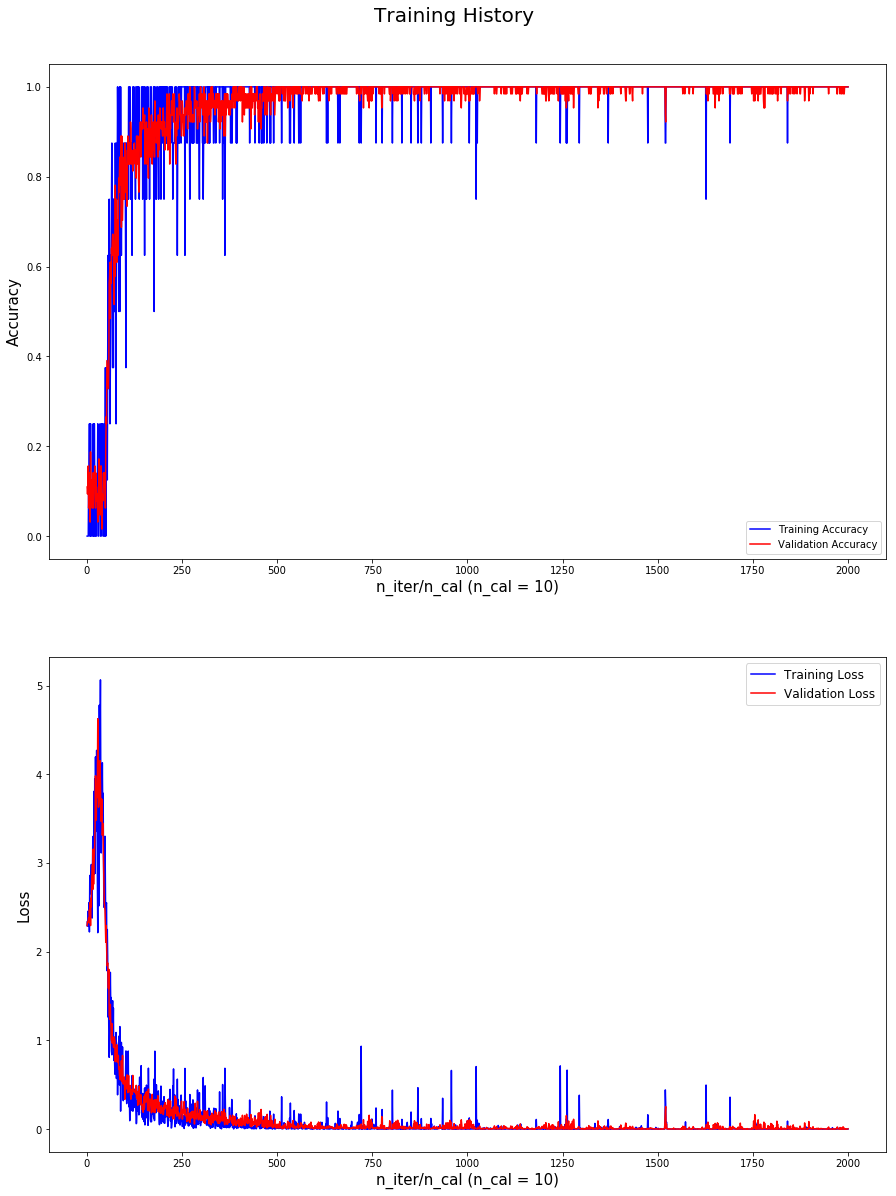

In [15]:
t_batch = 8
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)
lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
early_stopping = False

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
#     train_n_x, train_n_y = random_minibatch(train_noise_X, train_noise_Y, batch_size = t_batch)
#     train_x, train_y = np.concatenate((train_x, train_n_x), axis = 0), np.concatenate((train_y, train_n_y), axis = 0)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
#         valid_n_x, valid_n_y = random_minibatch(valid_noise_X, valid_noise_Y, batch_size = v_batch)
#         valid_x, valid_y = np.concatenate((valid_x, valid_n_x), axis = 0), np.concatenate((valid_y, valid_n_y), axis = 0)
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_8ch_res50g_v2_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50G_v2_HHT_8ch_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50G_v2_HHT_8ch_loss', np.array(loss_train))

hist.plot(n_cal)   

# sess.close()